<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks/10_LM_Transformers_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
!pip install transformers

In [11]:
from pprint import pprint

# Sentiment Analysis Example

We will use a great package from [hugging-face](https://huggingface.co/) called `Transformers`

In [2]:
from transformers import pipeline

They have already trained and ready pipelines, using BERT for things like sentiment-analysis classification:

In [3]:
nlp = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [4]:
nlp('we love you')

[{'label': 'POSITIVE', 'score': 0.9998704195022583}]

But be aware that although it may seem to be working well ...

In [5]:
nlp('I ate pizza with olives.')

[{'label': 'POSITIVE', 'score': 0.9042280912399292}]

In [6]:
nlp('I ate pizza with olives. it was cold')

[{'label': 'NEGATIVE', 'score': 0.9971919655799866}]

In [7]:
nlp('I ate pizza with olives, but the pizza was cold')

[{'label': 'NEGATIVE', 'score': 0.9980430603027344}]

... it might not always match your expectations:

In [8]:
nlp('It was cold outside. I ate pizza with olives.')

[{'label': 'NEGATIVE', 'score': 0.9729326963424683}]

In [ ]:
nlp('I am dying to see you')

[{'label': 'NEGATIVE', 'score': 0.8540693521499634}]

Let's test filling-in masked values:

In [9]:
nlp = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [12]:
pprint(nlp(f"{nlp.tokenizer.mask_token} is the president of the united states."))

[{'score': 0.24416854977607727,
  'sequence': 'Trump is the president of the united states.',
  'token': 7565,
  'token_str': 'Trump'},
 {'score': 0.20126576721668243,
  'sequence': 'Obama is the president of the united states.',
  'token': 33382,
  'token_str': 'Obama'},
 {'score': 0.07434763014316559,
  'sequence': ' Trump is the president of the united states.',
  'token': 140,
  'token_str': ' Trump'},
 {'score': 0.04162748157978058,
  'sequence': 'Clinton is the president of the united states.',
  'token': 36206,
  'token_str': 'Clinton'},
 {'score': 0.03837738186120987,
  'sequence': ' Obama is the president of the united states.',
  'token': 1284,
  'token_str': ' Obama'}]


In [13]:
pprint(nlp(f"There's no place like {nlp.tokenizer.mask_token}."))

[{'score': 0.037080999463796616,
  'sequence': "There's no place like hell.",
  'token': 7105,
  'token_str': ' hell'},
 {'score': 0.0345931351184845,
  'sequence': "There's no place like this.",
  'token': 42,
  'token_str': ' this'},
 {'score': 0.02284202165901661,
  'sequence': "There's no place like that.",
  'token': 14,
  'token_str': ' that'},
 {'score': 0.017316315323114395,
  'sequence': "There's no place like yours.",
  'token': 14314,
  'token_str': ' yours'},
 {'score': 0.01385930273681879,
  'sequence': "There's no place like ours.",
  'token': 15157,
  'token_str': ' ours'}]


# BERT

## Full Model Example

Now let's get the full model to work.

In [14]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM


In [15]:
import logging
logging.basicConfig(level=logging.INFO)

Remind yourself the discussion about BERT in the class. BERT has several special tokens. Specifically '[CLS]' begins a sequence, and '[SEP]' separates between sentences.

'[MASK]' is a special token that is mostly used during training, to teach the model to predict the missing words.

BERT needs 3 sequences as an input:
* The sentence words - tokenized and converted to a list of IDs
* Segment IDS - 0s and 1s indicating which words belong to which sentence
* and a position encoding vector

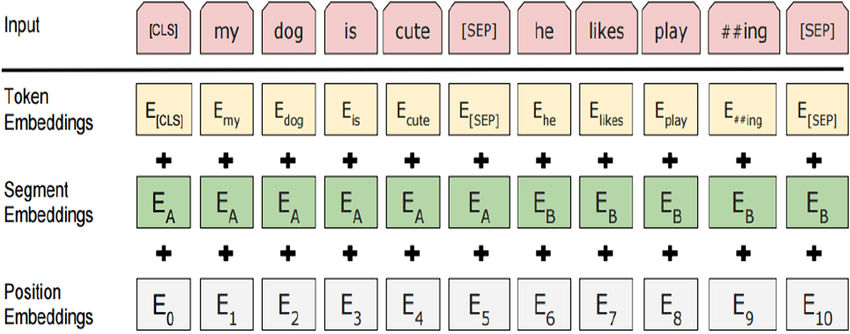

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])


In [18]:
tokenized_text

['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

In [19]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device)
model.to(device)

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    
    # Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]

# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
assert tuple(encoded_layers.shape) == (1, len(indexed_tokens), model.config.hidden_size)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device)
model.to(device)

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Fine-tune example.

This time we will fine-tune BERT on our special domain: **Pizza and Ice Cream**.

We will train a sentiment analysis on the topic - where 1 is positive, and 0 is a negative sentiment.


https://lilianweng.github.io/lil-log/2019/01/31/generalized-language-models.html#supervised-fine-tuning

In [21]:
from transformers import BertForSequenceClassification

In [22]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = 2,
                                                      return_dict=True)
model.train()

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

We don't want to train the WHOLE Bert. 

It took originally more than 4 days on 100s of machines to train it, on a massive amoutn of data. Instead, we want to only fine-tune the upper layers, to match our need.

The optimizer lets us choose layers where we want to focus at:

In [33]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)


In [34]:
text_batch = ["I love Ice Cream.", 
         "I don't care for Ice Cream.", 
         "I like my pizza cold", 
         "The pizza was cold", 
         "The ice cream was amazing", 
         "The pizza toppings wer boring",
         "He would like fries with that",
         "Ice cream is awesome"]
  
labels = [0, 
          1,
          1,
          0,
          1,
          0,
          1,
          1]

Tokenizing and encoding, can be done through the huggingFace library with either:

In [35]:
encoding = tokenizer(text_batch, 
                     return_tensors='pt', # pt = pyTorch 
                     padding=True, 
                     truncation=True)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

print(input_ids[0])
print(attention_mask[0])

tensor([ 101, 1045, 2293, 3256, 6949, 1012,  102,    0,    0,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


or (newer):

In [36]:
encoded_dict = tokenizer.encode_plus(
                        text_batch,                # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
pprint(encoded_dict)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[101, 100, 100, 100, 100, 100, 100, 100, 100, 102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [37]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in text_batch:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = True,
                        max_length = 32,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

### Your Turn:
convert the toy dataset to vectors, and input them into the model.

In [ ]:
### your code here:



In [ ]:
# Model fine-tuning (base-idea):

# labels = torch.tensor(labels).unsqueeze(0)
# outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
# loss = outputs.loss
# loss.backward()
# optimizer.step()


# Roberta


Instead of Big BERT, try using the smart sister: [roBERTa - A Robustly Optimized BERT Pretraining Approach](https://github.com/pytorch/fairseq/tree/master/examples/roberta)

**RoBERTa** (short for Robustly optimized BERT approach; Liu, et al. 2019) refers to a new receipt for training BERT to achieve better results, as they found that the original BERT model is significantly undertrained. The receipt contains the following learnings:

Train for longer with bigger batch size.
Remove the next sentence prediction (NSP) task.
Use longer sequences in training data format. The paper found that using individual sentences as inputs hurts downstream performance. Instead we should use multiple sentences sampled contiguously to form longer segments.
Change the masking pattern dynamically. The original BERT applies masking once during the data preprocessing stage, resulting in a static mask across training epochs. RoBERTa applies masks in 10 different ways across 40 epochs.
RoBERTa also added a new dataset CommonCrawl News and further confirmed that pretraining with more data helps improve the performance on downstream tasks. It was trained with the BPE on byte sequences, same as in GPT-2. They also found that choices of hyperparameters have a big impact on the model performance.


HuggingFace has full support of it - https://huggingface.co/transformers/model_doc/roberta.html - but few adjustments will be necessary to get it to work.

Check out the tutorial section for info how to use their impressive framework:
* https://huggingface.co/transformers/pretrained_models.html



Your task is to build a classifier.

You can choose between: 

## Sentence Acceptability
1. classify an acceptability of a sentence, https://arxiv.org/abs/1805.12471

For example:
* Good - What did Betsy paint a picture of?
* Bad - What was a picture of painted by Betsy?

The dataset can be downloaded from:
https://nyu-mll.github.io/CoLA/

And the corresponding kaggle competition:

https://www.kaggle.com/c/cola-out-of-domain-open-evaluation

## Toxic Comments Classification
2. Toxic comments classification

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Classify which of the comments are toxic, by fine-tuning RoBERTa on the dataset.